# Neural Network 

## 1. Imports

In [130]:
import HelperFunctions as hf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F

## 2. Fetching and preparing data

In [131]:
#Load in the raw data
calendar_df = hf.load_calendar_data()
prices_df = hf.load_sell_price_data()
sales_df = hf.load_sales_train_validation_data()

In [132]:
#Clean the raw data
df = hf.rawToClean(sales_df, calendar_df, prices_df, days=1300, items=100, dropNAPrices=True)

In [133]:
df.shape

(90854, 42)

In [134]:
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=1) #Mean of previous week
df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=1) #Mean of previous 28 days
df = hf.rollingMeanDemandFeature(df, windowSize=365, shift=1) 

df = hf.rollingStdDemandFeature(df, windowSize=7, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=28, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=365, shift=1)

In [135]:
df = hf.rollingMeanWeekday(df, weeks = 4, shift = 1) #mean of previous 3 weeks (for that particular weekday)
df = hf.rollingMeanWeekday(df, weeks = 8, shift = 1) #mean of previous 3 weeks (for that particular weekday)
df = hf.rollingMeanWeekday(df, weeks = 52, shift = 1) #mean of previous 3 weeks (for that particular weekday)

In [136]:
df = hf.lagFeature(df, var='sold', lag=1) #Amount sold day before
df = hf.lagFeature(df, var='sold', lag=7) #Amount sold a week before
df = hf.lagFeature(df, var='sold', lag=28) #Amount sold 28 days before
df = hf.lagFeature(df, var='sold', lag=365) #Amount sold 28 days before

In [137]:
df.dropna(inplace=True) #Drop rows with NAs (as result of lagged features)

In [138]:
df.describe()

,sell_price,rolling_mean_7_1,rolling_mean_28_1,rolling_mean_365_1,rolling_std_7_1,rolling_std_28_1,rolling_std_365_1,rolling_mean_4_1,rolling_mean_8_1,rolling_mean_52_1
count,56589.000000,56589.000000,56589.000000,56589.000000,5.658900e+04,56589.000000,5.658900e+04,56589.000000,56589.000000,56589.000000
mean,4.200771,1.429119,1.431855,1.491759,1.106652e+00,1.246270,1.478557e+00,1.433834,1.440112,1.492277
std,2.953065,3.608648,3.496928,3.549106,1.711430e+00,1.763194,1.950406e+00,3.646157,3.570370,3.575548
min,0.580000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.104548e-09,0.000000,0.000000,0.000000
25%,1.980000,0.000000,0.142857,0.227397,3.392538e-07,0.390021,5.450777e-01,0.000000,0.125000,0.230769
50%,3.650000,0.428571,0.500000,0.575342,7.559289e-01,0.826160,9.789059e-01,0.500000,0.500000,0.576923
75%,5.220000,1.285714,1.250000,1.268493,1.345185e+00,1.452511,1.617364e+00,1.250000,1.250000,1.269231
max,14.940000,59.714286,42.142857,30.706849,2.271459e+01,20.466872,1.503589e+01,56.250000,47.000000,35.596154


In [139]:
#Standardise features
cols_to_norm = ['d','wday','month','year','sell_price', "rolling_mean_365_1", "rolling_std_28_1",\
                "rolling_std_365_1", "rolling_mean_4_1", "rolling_mean_8_1", "rolling_mean_52_1", \
                "rolling_mean_28_1", "rolling_std_7_1", "rolling_mean_7_1"]

df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])

In [140]:
df.describe()

,d,wday,month,year,sell_price,rolling_mean_7_1,rolling_mean_28_1,rolling_mean_365_1,rolling_std_7_1,rolling_std_28_1,rolling_std_365_1,rolling_mean_4_1,rolling_mean_8_1,rolling_mean_52_1
count,56589.000000,56589.000000,56589.000000,56589.000000,56589.000000,56589.000000,56589.000000,56589.000000,5.658900e+04,56589.000000,56589.000000,56589.000000,56589.000000,56589.000000
mean,0.552767,0.499476,0.480789,0.504983,0.252143,0.023933,0.033976,0.048581,4.871989e-02,0.060892,0.098335,0.025490,0.030641,0.041922
std,0.274526,0.333773,0.294267,0.379693,0.205645,0.060432,0.082978,0.115580,7.534500e-02,0.086149,0.129717,0.064821,0.075965,0.100448
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.326552,0.166667,0.272727,0.000000,0.097493,0.000000,0.003390,0.007405,1.493550e-08,0.019056,0.036252,0.000000,0.002660,0.006483
50%,0.567452,0.500000,0.454545,0.500000,0.213788,0.007177,0.011864,0.018737,3.327945e-02,0.040366,0.065105,0.008889,0.010638,0.016207
75%,0.790150,0.833333,0.727273,1.000000,0.323120,0.021531,0.029661,0.041310,5.922122e-02,0.070969,0.107567,0.022222,0.026596,0.035656
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [141]:
df.columns

Index(['id', 'd', 'sold', 'wday', 'month', 'year', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'Cultural', 'National', 'Religious',
       'Sporting', 'NoEvent', 'Christmas', 'weekend', 'midweek', 'monfri',
       'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2',
       'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS', 'HOBBIES', 'HOUSEHOLD', 'CA_1',
       'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3',
       'CA', 'TX', 'WI', 'rolling_mean_7_1', 'rolling_mean_28_1',
       'rolling_mean_365_1', 'rolling_std_7_1', 'rolling_std_28_1',
       'rolling_std_365_1', 'rolling_mean_4_1', 'rolling_mean_8_1',
       'rolling_mean_52_1', 'sold_lag_1', 'sold_lag_7', 'sold_lag_28',
       'sold_lag_365'],
      dtype='object')

In [117]:

df_item = df.loc[df.id == "FOODS_2_360_TX_3_validation"]
df_test = df.loc[df.d > 1200/1300]
df = df.loc[df.d <= 1200/1300]

In [122]:
df.columns

Index(['id', 'd', 'sold', 'wday', 'month', 'year', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'Cultural', 'National', 'Religious',
       'Sporting', 'NoEvent', 'Christmas', 'weekend', 'midweek', 'monfri',
       'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2',
       'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS', 'HOBBIES', 'HOUSEHOLD', 'CA_1',
       'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3',
       'CA', 'TX', 'WI', 'rolling_mean_7_1', 'rolling_mean_28_1',
       'rolling_mean_365_1', 'rolling_std_7_1', 'rolling_std_28_1',
       'rolling_std_365_1', 'rolling_mean_4_1', 'rolling_mean_8_1',
       'rolling_mean_52_1', 'sold_lag_1', 'sold_lag_7', 'sold_lag_28',
       'sold_lag_365'],
      dtype='object')

## Means

In [147]:
df["sold"] = df["sold"].astype(float)

In [150]:
df_means = df.groupby("id", as_index = False).mean()

In [165]:
preds = []
for index, row in df.iterrows():
    preds.append(df_means.loc[df_means.id == row.id].sold)

In [166]:
mean_squared_error(preds, df.sold.values)

5.765734736769597

In [127]:
df.drop(['id'], axis=1, inplace=True) #Drop the id column

In [170]:

y = df.pop("sold")
y = y.values
y = y.astype(float)


In [129]:
df = df.astype(float)

## feature selection

In [17]:

# remove = True
# while remove == True:
#     mod = sm.OLS(y, df)
#     res = mod.fit()
#     pval = pd.DataFrame(res.pvalues)
#     if len(pval.loc[pval[0] > 0.05]) == 0:
#         remove = False
#     else:
#         worst_col = pval.loc[pval[0] > 0.05].T.columns[pval.loc[pval[0] > 0.05][0].argmax()]
#         print(worst_col , pval.loc[pval[0] > 0.05].max()[0])
#         df = df.drop([worst_col], axis = 1)
#         df_test = df_test.drop([worst_col], axis = 1)
        
    

CA_3 0.9573086579461667
wday 0.9031888194426605
CA_2 0.8526100401403813
TX_3 0.8393378295210506
monfri 0.8031918030488344
WI_3 0.7510915257652349
HOBBIES_1 0.7582294209270444
TX_1 0.652959740560265
WI 0.6338748184962121
FOODS_1 0.8418019696914507
FOODS 0.692343221239845
National 0.6453054508971026
TX 0.6638050450363444
month 0.5587255721052201
Sporting 0.5786571285420568
HOUSEHOLD_1 0.559927642187779
HOUSEHOLD_2 0.9878297306590796
HOBBIES_2 0.5490037198321729
WI_1 0.4831432630976341
WI_2 0.5052296219932679
CA 0.5679698102780112
TX_2 0.6239107975090082
sell_price 0.42576136906438167
HOBBIES 0.30557110588653064
HOUSEHOLD 0.5580925292095945
FOODS_2 0.43229158827686276
FOODS_3 0.44527419382933875
CA_1 0.17108248520362623
CA_4 0.20706324953139837
snap_WI 0.15613874678203885
d 0.12662041579189648
year 0.6585428554854749
rolling_mean_365_1 0.08457271011862434
rolling_std_28_1 0.07472851561046175
Religious 0.052607058354707664


In [18]:

X = df.values


In [19]:
X.shape

(51250, 18)

## 3. Setting up loaders

In [20]:
X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [21]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
X_train.shape, y_train.shape

(torch.Size([41000, 18]), torch.Size([41000]))

In [23]:
# create data loaders

from torch.utils import data

traindataset = data.TensorDataset(X_train, y_train) # create your datset
trainloader = data.DataLoader(traindataset, batch_size=1024, shuffle=True) # create your dataloader


testdataset = data.TensorDataset(X_test,y_test) # create your datset
testloader = data.DataLoader(testdataset, batch_size=1024, shuffle=True) # create your dataloader



## 4. Building neural net

In [24]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        
        return out

In [25]:
from torchbearer import Trial
import torchbearer
from sklearn.metrics import mean_squared_error

In [26]:
# build the model 
model = BaselineModel(X_train.shape[1], 512)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

loss_plot = []
loss_eval = []
# the epoch loop
for epoch in range(20):
    running_loss = 0.0

    for data in trainloader:
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        running_loss += loss.item()
    loss_plot.append(running_loss/len(trainloader))
    
    model.eval()
    mse = 0
    for index, i in enumerate(testloader):

        inputs, labels = i
          
        outputs = model(inputs)
        outputs = outputs.detach().numpy()
        mse += mean_squared_error(labels, outputs)
    loss_eval.append(mse/len(testloader))
    
    
    print("Epoch %d, loss %4.2f, test loss %4.2f" % (epoch, running_loss/len(trainloader), mse/len(testloader)))
print('**** Finished Training ****')


Epoch 0, loss 7.19, test loss 4.92
Epoch 1, loss 5.40, test loss 8.75
Epoch 2, loss 5.94, test loss 5.15
Epoch 3, loss 5.39, test loss 4.82
Epoch 4, loss 5.15, test loss 4.99
Epoch 5, loss 5.31, test loss 4.85
Epoch 6, loss 5.03, test loss 4.92
Epoch 7, loss 5.19, test loss 4.96
Epoch 8, loss 5.07, test loss 4.65
Epoch 9, loss 5.35, test loss 7.57
Epoch 10, loss 5.78, test loss 4.58
Epoch 11, loss 4.85, test loss 4.77
Epoch 12, loss 4.78, test loss 4.60
Epoch 13, loss 4.76, test loss 4.41
Epoch 14, loss 4.68, test loss 4.42
Epoch 15, loss 4.83, test loss 4.40
Epoch 16, loss 4.72, test loss 6.49
Epoch 17, loss 4.91, test loss 4.64
Epoch 18, loss 4.68, test loss 4.77
Epoch 19, loss 4.76, test loss 4.39
**** Finished Training ****


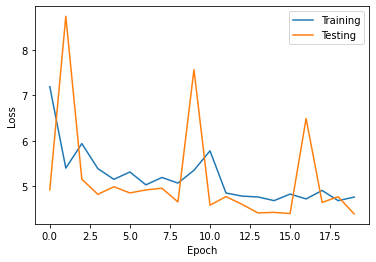

In [27]:
import matplotlib.pyplot as plt
plt.plot(loss_plot, label = "Training")
plt.plot(loss_eval, label = "Testing")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Testing Model 1200-1300

In [32]:
def prepare(df):
    df= df.drop("id", axis = 1)
    y = df.pop("sold")
    y =  torch.FloatTensor(y.values.astype(float))
    return(df, y)

In [33]:
df_test, y_test= prepare(df_test)

In [34]:
def evaluate(model, df, y):
    model.eval()

    preds = []
    for index, i in enumerate( torch.FloatTensor(df.values.astype(float))):
        inputs = i
        label = y[index]

        outputs = model(inputs)
        outputs = outputs.detach().numpy()
        preds.append(outputs)
    preds = np.asarray(preds)
    preds.shape = (preds.shape[0],)
    return(preds)

In [35]:
preds_test = evaluate(model, df_test, y_test)

In [36]:
mean_squared_error(preds_test, y_test)

3.8291903

## Means

In [168]:
preds = []
for index, row in df_test.iterrows():
    preds.append(df_means.loc[df_means.id == row.id].sold)

In [169]:
mean_squared_error(preds, y_test)

5.3210321235931834

## Department 

In [89]:
def depMSE(col):
    df_dep = df[(df[col] == 1)]
    df_dep, y_dep = prepare(df_dep)
    preds_dep = evaluate(model, df_dep, y_dep)
    return(mean_squared_error(preds_dep, y_dep))

In [90]:
depMSE("FOODS")

8.094155

In [91]:
depMSE("HOUSEHOLD")

1.3515781

In [92]:
depMSE("HOBBIES")

0.47455132

## Department Length STD and Mean

In [96]:
[len(df[(df[i] == 1)]) for i in ["FOODS", "HOUSEHOLD", "HOBBIES"]]

[26351, 15833, 9066]

In [109]:
[round((df.sold[(df[i] == 1)]).values.mean(), 2) for i in ["FOODS", "HOUSEHOLD", "HOBBIES"]]

[2.22, 0.83, 0.33]

In [110]:
[round((df.sold[(df[i] == 1)]).values.std(), 2) for i in ["FOODS", "HOUSEHOLD", "HOBBIES"]]

[5.51, 1.64, 0.79]

## MSE BY STATE

In [116]:
depMSE("TX"), depMSE("CA"), depMSE("WI")

(8.450689, 4.255197, 1.2261016)

In [117]:
[len(df[(df[i] == 1)]) for i in ["TX", "CA", "WI"]]

[14815, 22819, 13616]

In [118]:
[round((df.sold[(df[i] == 1)]).values.mean(), 2) for i in ["TX", "CA", "WI"]]

[2.16, 1.51, 0.6]

In [119]:
[round((df.sold[(df[i] == 1)]).values.std(), 2) for i in ["TX", "CA", "WI"]]

[6.45, 3.14, 1.28]

## TESTING FOODS_2_360_TX_3 predictions.xlsx

In [192]:
df_item = df_item.drop("id", axis = 1)

In [193]:
y_item = df_item.pop("sold")

In [194]:
y_item =  torch.FloatTensor(y_item.values.astype(float))

In [196]:
model.eval()

preds = []
for index, i in enumerate( torch.FloatTensor(df_item.values[-100:].astype(float))):
    inputs = i
    label = y_item[index]

    outputs = model(inputs)
    outputs = outputs.detach().numpy()
    preds.append(outputs)


In [112]:
len(preds)

100

In [185]:
m = np.asarray([df_means.loc[df_means.id == "FOODS_2_360_TX_3_validation"].sold.values] * 100)

In [186]:
m.shape = (100,)

In [207]:
preds = pd.read_excel("FOODS_2_360_TX_3 predictions.xlsx",  engine='openpyxl').values

preds.shape = (100,)

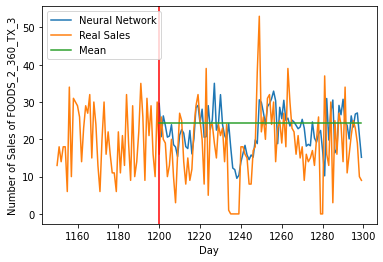

In [224]:

plt.plot([i for i in range(1200, 1300)], preds, label = "Neural Network")
plt.plot([i for i in range(1150, 1300)], y_item[-150:], label = "Real Sales")
plt.axvline(1200, c = "r")
plt.plot([i for i in range(1200, 1300)],m, label = "Mean")
plt.xlabel("Day")
plt.ylabel("Number of Sales of FOODS_2_360_TX_3")
plt.legend()

In [211]:
preds = np.asarray(preds)

In [125]:
preds.shape = (100,)

In [134]:
df_pred = pd.DataFrame(preds).T

In [139]:
df_pred.to_excel("FOODS_2_360_TX_3 predictions.xlsx", index = False)

In [212]:
df = pd.read_excel("FOODS_2_360_TX_3 predictions.xlsx",  engine='openpyxl')

In [213]:
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,29.62118,20.697523,26.282949,23.723934,20.582651,20.892366,23.925562,18.570688,17.925602,15.371912,...,30.741135,24.644682,23.731657,20.104092,26.284115,23.300997,26.780066,27.07473,20.991177,15.175308


In [220]:
df_withmean = pd.concat([df, pd.DataFrame(m).T], axis = 0)

In [221]:
df_withmean.to_excel("FOODS_2_360_TX_3 predictions.xlsx", index = False)

In [35]:
# model.eval()
# plt.figure(figsize = (10,10))
# for index, i in enumerate(trainloader):
#     if index < 1:
#         inputs, labels = i
          
#         outputs = model(inputs)
#         outputs = outputs.detach().numpy()
#         plt.plot([i for i in range(len(labels))], labels, label = "True Sales")
#         print(outputs)
#         plt.plot(outputs, label = "Predicted Sales")
#         plt.legend()
# #         plt.ylim(0, 30)
#         plt.xlim(0, 100)
#         #print(inputs, labels)
#     else:
#         break

In [36]:
# model.eval()
# plt.figure(figsize = (10,10))
# for index, i in enumerate(testloader):
#     if index < 1:
#         inputs, labels = i
          
#         outputs = model(inputs)
#         outputs = outputs.detach().numpy()
#         plt.plot([i for i in range(len(labels))], labels, label = "True Sales")
#         print(outputs)
#         plt.plot(outputs, label = "Predicted Sales")
#         plt.legend()
# #         plt.ylim(0, 30)
#         plt.xlim(0, 100)
#         #print(inputs, labels)
#     else:
#         break

In [28]:
model.eval()

mse = 0

for data in trainloader:
    inputs, labels = data
    
    outputs = model(inputs)
    
    outputs = outputs.detach().numpy()
    mse += mean_squared_error(labels, outputs)
print("Train: ", mse/len(trainloader))

Train:  4.504484135930131


In [29]:
model.eval()

mse = 0

for data in testloader:
    inputs, labels = data
    
    outputs = model(inputs)
    
    outputs = outputs.detach().numpy()
    mse += mean_squared_error(labels, outputs)
print("Test: ", mse/len(testloader))

Test:  4.5568133050745185


## K-Fold 

In [37]:
def train_model(X_train, y_train, X_test, y_test):
        
        # create data loaders

    from torch.utils import data
    traindataset = data.TensorDataset(X_train, y_train) # create your datset
    trainloader = data.DataLoader(traindataset, batch_size=1024, shuffle=True) # create your dataloader


    testdataset = data.TensorDataset(X_test,y_test) # create your datset
    testloader = data.DataLoader(testdataset, batch_size=1024, shuffle=True) # create your dataloader


        
        
    # build the model 
    model = BaselineModel(X_train.shape[1], 512)

    # define the loss function and the optimiser
    loss_function = nn.MSELoss()
    optimiser = optim.Adam(model.parameters())

    loss_plot = []
    loss_eval = []
    # the epoch loop
    for epoch in range(20):
        running_loss = 0.0

        for data in trainloader:
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimiser.zero_grad()

            # forward + loss + backward + optimise (update weights)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = loss_function(outputs, labels)
            loss.backward()
            optimiser.step()

            # keep track of the loss this epoch
            running_loss += loss.item()
        loss_plot.append(running_loss/len(trainloader))

        model.eval()
        mse = 0
        for index, i in enumerate(testloader):

            inputs, labels = i

            outputs = model(inputs)
            outputs = outputs.detach().numpy()
            mse += mean_squared_error(labels, outputs)
        loss_eval.append(mse/len(testloader))


        print("Epoch %d, loss %4.2f, test loss %4.2f" % (epoch, running_loss/len(trainloader), mse/len(testloader)))
    print('**** Finished Training ****')

    return(loss_plot[-1], loss_eval[-1])



In [38]:
from sklearn.model_selection import KFold
from torch.utils import data
kf5 = KFold(n_splits=6, shuffle=False)
def kfold_val(X, Y):
    res= []

    for index, (train_index, test_index) in enumerate(kf5.split(range(len(X)))):
        if index < 5:
            res.append(train_model(X[train_index], Y[train_index],X[train_index], Y[train_index]))

    return(np.array(res))

In [39]:
res = kfold_val(X, y)

Epoch 0, loss 5.68, test loss 4.84
Epoch 1, loss 4.88, test loss 4.90
Epoch 2, loss 4.83, test loss 4.70
Epoch 3, loss 4.85, test loss 4.71
Epoch 4, loss 4.76, test loss 4.83
Epoch 5, loss 4.86, test loss 5.20
Epoch 6, loss 4.91, test loss 4.57
Epoch 7, loss 4.66, test loss 4.48
Epoch 8, loss 4.66, test loss 4.74
Epoch 9, loss 4.54, test loss 4.39
Epoch 10, loss 4.50, test loss 5.27
Epoch 11, loss 4.49, test loss 4.26
Epoch 12, loss 4.44, test loss 4.58
Epoch 13, loss 4.57, test loss 5.20
Epoch 14, loss 4.56, test loss 4.18
Epoch 15, loss 4.42, test loss 4.27
Epoch 16, loss 4.26, test loss 4.16
Epoch 17, loss 4.19, test loss 4.13
Epoch 18, loss 4.21, test loss 4.06
Epoch 19, loss 4.37, test loss 4.82
**** Finished Training ****
Epoch 0, loss 6.82, test loss 6.49
Epoch 1, loss 5.74, test loss 5.40
Epoch 2, loss 5.37, test loss 5.32
Epoch 3, loss 5.54, test loss 6.00
Epoch 4, loss 5.50, test loss 5.31
Epoch 5, loss 5.28, test loss 5.45
Epoch 6, loss 5.39, test loss 5.23
Epoch 7, loss 5.2

In [40]:
res

array([[4.37453762, 4.81888207],
       [4.75242199, 5.01156299],
       [4.73216215, 4.99203589],
       [4.71438932, 4.82818273],
       [4.57204967, 4.48658351]])

In [41]:
res = np.asarray(res)

In [42]:
np.mean(res[:, 0]), np.std(res[:, 0])

(4.6291121505555655, 0.14224003308188585)

In [43]:
np.mean(res[:, 1]), np.std(res[:, 1])

(4.82744943641481, 0.1882817148730687)